# Intern BankFind API Project
### Thomas Drake

In [53]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import numpy as np
import shap
from sklearn.cluster import KMeans
sns.set()

import import_ipynb
from BankFindSearch import search

# Problem Statement

### Background
The FDIC's BankFind API gives miners and developers access to publicly available bank data. We want to interface with this API to dynamicly pull up-to-date data for our analysis. The API also supports filtering and aggragating the data we are searching for, so we must ensure that we can also achieve this through our code in Python. 
### Question
**Which structural features of a bank are most strongly associated with factors indicative of success?** More specificially, we want to use the available data on institutions to determine which variables are most strongly correlated with a bank's 'success', as measured by a common measure like Net Income, Return on Assets, etc. (more on this later). Note that, naturally, we are limited to the variables returned by BankFind.

# Procedure Outline

To address the problem statement, I will take the following procedure:
1. Develop a streamlined system for interfacing with the BankFind API using Python to extract data
2. Illustrate the data and build some context through some initial visualizations and cluster analysis
3. Use XGBoost to build a machine learning model that will input structural bank data and output a prediction for how that bank will perform
4. Analyze the XGBoost model to determine which structural variables were most strongly correlated with bank performance
5. Conclude my analysis by reflecting on the results, what could have been improved, and what can be done next

# Section 1: Interfacing with BankFind

To pull data directly from the FDIC's public database, I wrote a fairly simple ```search``` function that makes calls to the BankFind API, and returns the search results. I have not included this function directly in this document, as its details are not important for the data analysis, but the function is imported from a separate file titled ```BankFindSearch```, found in the same directory as the document you are reading. For further details and clarification on the function and how it works, please refer to ```BankFindSearch```.

# Section 2: Data Overview
The BankFind API's ```institutions``` endpoint contains over 27,000 financial institutions, including almost 5,000 that are active and insured by the FDIC. In this section, we will use some visualizations and clustering analysis as an introduction to the dataset. Specifically, we will try to classify these institutions by their size to get a sense of the scale of the data, and the disparities in sizes of different banks. This will ultimately give us good context for our main analysis and help us to decide how to measure a bank's 'success'.

### Data Loading, Cleaning, and Scaling

In [85]:
#we will use offices and assets as an indicator of an institutions size
variables = ['OFFICES','ASSET']

#Pull active bank data from API using search according to specified variables
all_banks = search('institutions', 'ACTIVE:1',variables + ['NAME'])

In [86]:
#Convert search result to pandas dataframe
frame = pd.DataFrame(all_banks, columns = variables)
names = pd.DataFrame(all_banks, columns = ['NAME'])
new_frame = frame.copy()

#cast all object types to float types
new_frame[variables[0]] = pd.to_numeric(frame[variables[0]], downcast = "float")
new_frame[variables[1]] = pd.to_numeric(frame[variables[1]], downcast = "float")

#drop missing values
data = new_frame.dropna()

#add bank names which allows us to see results of cluster analysis
data_with_names = data.join(names)

#here we standardize the OFFICES and ASSETS data to avoid heavy bias towards ASSETS
#OFFICES data is in the thousands and ASSETS data is in the billions
scaler = preprocessing.StandardScaler()
s_data = scaler.fit_transform(data)
scaled_data = pd.DataFrame(s_data, columns = ['OFFICES', 'ASSET'])

### Cluster Analysis

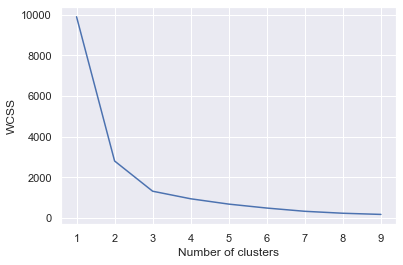

In [87]:
#use elbow method to determine optimal number of clusters
wcss = []
for i in range(1,10):
    kmeans = KMeans(i)
    kmeans.fit(scaled_data)
    wcss.append(kmeans.inertia_)
plt.xlabel("Number of clusters")
plt.ylabel("WCSS")
plt.plot(range(1,10), wcss)

The elbow method helps us to determine the optimal number of clusters to use in our analysis. The optimal number of clusters should both minimize the within-cluster sum of squares (WCSS - y axis on graph above), and keep our number of clusters low. The 'elbow method' allows us to find this optimal point, by seeing where the 'elbow' is on the graph shown above. This number appears to be at 3, since after 3 clusters, adding additional clusters does not significantly decrease the WCSS. Therefore, we will use 3 clusters in our analysis.

In [88]:
#perform cluster analysis
kmeans = KMeans(3)
kmeans.fit(data)
clusters = kmeans.fit_predict(scaled_data)
data_clusters = data.copy()
data_clusters['Cluster'] = clusters

#prepare data for plotting
data_names_clusters = data_with_names.join(data_clusters['Cluster'])
data_x = data_clusters[variables[0]]
data_y = data_clusters[variables[1]]

In [89]:
#a function we will use to plot graphs and avoid repeating code 
def plot_banks(yaxis, lim=False, xlim=0, ylim=0, lines=False, x = 0, y = 0, fontsize=17):
    dash_line_color = "black"
    if lim:
        plt.xlim(0,xlim)
        plt.ylim(0,ylim*10**9)
    plt.scatter(data_x,data_y, c = data_clusters['Cluster'], cmap='Accent')
    if lines:
        plt.hlines(y*10**9,0,x,color=dash_line_color, linestyles = 'dashed')
        plt.vlines(x,0,y*10**9,color=dash_line_color, linestyles = 'dashed')
    plt.xlabel(variables[0], fontsize=17)
    plt.ylabel(variables[1] + ' (' + yaxis + ')', fontsize=fontsize)
    plt.show()

### Plots and Cluster Analysis Results

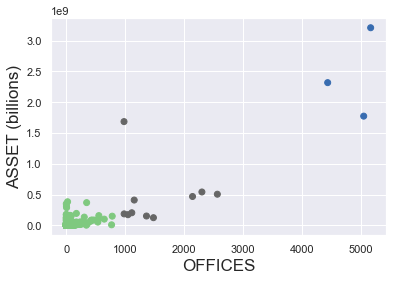

In [90]:
plot_banks("billions")

#### Description
Above is a scatterplot of all active institutions in the FDIC's database plotted based on the number of offices and the number of assets (in Billions of dollars). The three different colors show the results of our cluster analysis.

In [91]:
cluster1 = []
cluster2 = []
cluster3 = []
for i in range(0,len(data_names_clusters)):
    cluster =  data_names_clusters.iloc[i, 3]
    name = data_names_clusters.iloc[i, 2]
    if cluster == 0:
        cluster3.append(name)
    elif cluster == 1:
        cluster1.append(name)
    elif cluster == 2:
        cluster2.append(name)

#### Clustering Results

We obtained 3 clusters:
1. **Blue: The largest banks** (very large assets and high number of offices) - this is the smallest cluster, containing only three institutions (shown below). While all three of these banks are very large, JPMorgan Chase Bank beats all others by fairly big margins in both number of offices and assets held.

In [92]:
#print the three banks in cluster 1
for bank in cluster1:
    print(bank)

Bank of America, National Association
Wells Fargo Bank, National Association
JPMorgan Chase Bank, National Association


2. **Gray: Large but less dominate banks** (lots of offices, but less assets than the largest banks) - This cluster contains 10 banks that share the property of having many offices and much higher than average assets, though not nearly to the extent of cluster 1. One note here is that one bank in particular stands out within this cluster - Citibank has more assets than the rest of the cluster, nearly reaching the levels of the largest banks - however, it has much less offices compared to banks in cluster 1 which likely keeps it in cluster 2. Also, 3 banks in cluster 2 stand out for their high number of offices - PNC, US Bank, and Truist. 

In [93]:
#print banks in cluster 2
for bank in cluster2:
    print(bank)

Regions Bank
KeyBank National Association
TD Bank, National Association
Citizens Bank, National Association
PNC Bank, National Association
U.S. Bank National Association
The Huntington National Bank
Fifth Third Bank, National Association
Citibank, National Association
Truist Bank


3. **Green: Medium-large to small banks** - this cluster contains the VAST majority of institutions - in fact, 99.7% of all institutions are in this cluster! - this result really illustrates the extent to which the top tier of banks dominate most everyone in terms of their size. 

In [94]:
#print the proportion of all banks found in cluster 3
print(len(cluster3) / len(data))

0.9973721447341823


#### Zooming into Cluster 3

To further illustrate the size of cluster 3, we can zoom in the bottom left portion of the graph below to show cluster 3 more clearly. The black dashed-line indicates the section we are zooming into for each successive graph.

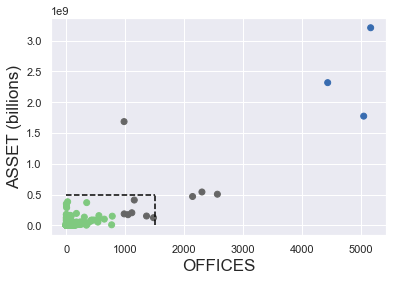

In [95]:
plot_banks("billions", lines=True, x=1500, y=.5)

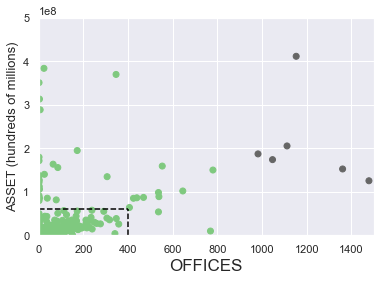

In [96]:
#now zoom in
plot_banks("hundreds of millions", True, 1500, .5, True, 400, .06, 13)

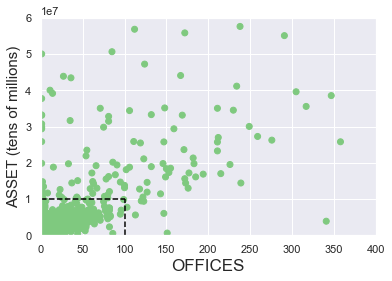

In [97]:
#zoom in again
plot_banks("tens of millions", True, 400, .06, True, 100, .01, 15)

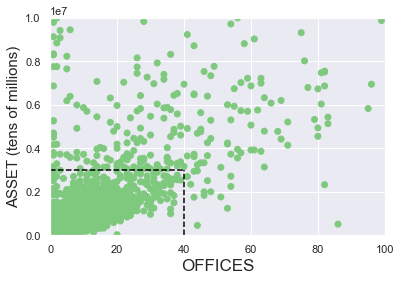

In [98]:
#and again
plot_banks("tens of millions", True, 100, .01, True, 40, .003, 15)

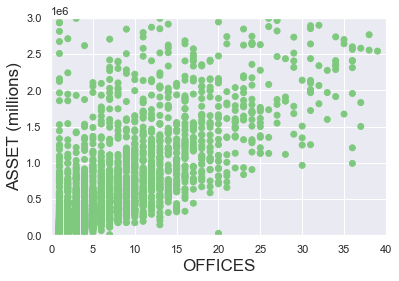

In [99]:
#and zoom one more time!
plot_banks("millions", True, 40, .003)

### Summary 

In this section, we were introduced to the data we are dealing with, and got a sense for the magnitude with which the data scales. Additionally, this analysis raises a few questions me must address before our main analysis moving forward:
- Given that some of the largest banks are extreme outliers in terms of their size (offices and assets), should we remove these datapoints from our main analysis?

This is a good and important question that must be considred. Since the top .3% of banks are so much larger in assets and number of offices compared to the average bank, there is certainly an argument to be made for removing these points when completing our analysis. Doing so would potentially produce a model that would be more accurate for an average size bank. However, I ultimately decided to leave these points in my analysis for a few reasons. First, while the largest banks are extreme outliers in terms of their assets and offices, they are equally as dominant in terms of their influence and market share, meaning that leaving these banks out would neglect a massive portion of banking done in the US. Additionally, I hope to eliminate some bias produced by these large outliers in other ways, particularly by ensuring that the metric I use to measure bank 'success' is standardized to account for large disparities in assets and size. This point leads directly into the next question that we must address before moving to the main analysis:
- What measure of a bank's 'success' should we use to ensure that our analysis is not heavily biased towards larger banks (like those from clusters 1 & 2)?

There are a few different measures that are commonly used as measures of a bank's performance and are returned by the BankFind API. These include but are not limited to Net Income, Return on Equity, and Return on Assets. While each of these are certainly different, they are all highly correlated together, so they will all give us the same rough sense on whether a bank is performing postively or negatively. Given our understanding of the large skew in bank size, it is especially important to choose a metric that is standardized to account for disparities in scale. For these reasons, I chose to use Return on Assets (ROA) as my measure of bank performance - ROA represents net income after taxes and extraordinary items as a percent of average total assets. Because ROA is given as a percentage of total assets, we avoid introducing heavy bias towards the largest banks. If we had instead used Net Income as our measure, our model would be biased towards the biggest banks, as these banks have the most assets and have the potential of having higher net income by multiple orders of magnitude.

With our background research and data introduction complete, we can now continue to our main analysis.

# Section 3: Data Analysis

### Declaration of Structural Bank Features

Our first step in our analysis is to determine which of the variables returned by BankFind we will use as inputs. Many of the return values from the API are not useful for our kind of analysis - these include any names, ID codes, dates, locations, categorical variables where all or nearly all banks have the same value, or variables that contain too many missing values. After filtering out these useless variables, I obtained a list of variables which are declared below. They are organized into two lists, one which contains all categorical variables which can be represented with binary indicators (```flag_cols```), and another which contains quantitative values (```numeric_cols```).

In [100]:
flag_cols = ['CB', 'CHRTAGNT',  'CFPBFLAG', 'FEDCHRTR',
            'FORM31', 'HCTMULT', 'IBA', 'INSCOML', 'INSSAVE', 'MDI_STATUS_DESC', 'REGAGNT', 'SPECGRP',  'STCHRTR', 'SUBCHAPS',
            'TRACT', 'TRUST']
numeric_cols = ['ASSET', 'DEP', 'EQ', 'OFFICES']

### Collecting the Data

In [101]:
#search for active banks and return requested variables
r = search("institutions", 'ACTIVE:1',  flag_cols + numeric_cols + ['ROA'])

### Cleaning the Data

In [102]:
#load the data into pandas dataframes and drop missing values
flag_frame = pd.DataFrame(r, columns = flag_cols + ['ROA'])
numeric_frame = pd.DataFrame(r, columns = numeric_cols)
flag_data = flag_frame.dropna()
numeric_data = numeric_frame.dropna()

In [103]:
#create necessary indicator variables and cast all strings to numbers
flag_cdata = flag_data.drop('SPECGRP', axis = 1)
flag_cdata['CHRTAGNT'] = flag_data['CHRTAGNT'].map(lambda x: 1 if x == 'STATE' else 0)
flag_cdata['MDI_STATUS_DESC'] = flag_data['MDI_STATUS_DESC'].map(lambda x: 0 if x == "NONE" else 1)
flag_cdata['REGAGNT'] = flag_data['REGAGNT'].map(lambda x: 0 if x == "FDIC" else 1)
flag_cdata['COMLS'] = flag_data['SPECGRP'].map(lambda x: 1 if x == 4 else 0)
flag_cdata['AGRS'] = flag_data['SPECGRP'].map(lambda x: 1 if x == 2 else 0)
flag_cdata['CONLS'] = flag_data['SPECGRP'].map(lambda x: 1 if x == 6 else 0)
flag_cdata['CCS'] = flag_data['SPECGRP'].map(lambda x: 1 if x == 3 else 0)
flag_cdata['INTLS'] = flag_data['SPECGRP'].map(lambda x: 1 if x == 1 else 0)
flag_cdata['MRLS'] = flag_data['SPECGRP'].map(lambda x: 1 if x == 5 else 0)
flag_cdata['OOBS'] = flag_data['SPECGRP'].map(lambda x: 1 if x == 9 else 0)
flag_cdata['CB'] = flag_data['CB'].map(lambda x: 1 if x == '1' else 0)
flag_cdata['FORM31'] = flag_data['FORM31'].map(lambda x: 1 if x == '1' else 0)
flag_cdata['HCTMULT'] = flag_data['HCTMULT'].map(lambda x: 1 if x == '1' else 0)
flag_cdata['TRACT'] = flag_data['TRACT'].map(lambda x: 1 if x == '1' else 0)
flag_cdata['TRUST'] = flag_data['TRUST'].map(lambda x: 1 if x == '1' else 0)
flag_cdata['SUBCHAPS'] = flag_data['SUBCHAPS'].map(lambda x: 1 if x == '1' else 0)

In [104]:
#cast our quantitative data from string objects to floats
numeric_cdata= numeric_data.copy()
numeric_cdata['ASSET'] = pd.to_numeric(numeric_data['ASSET'], downcast = "float")
numeric_cdata['DEP'] = pd.to_numeric(numeric_data['DEP'], downcast = "float")
numeric_cdata['EQ'] = pd.to_numeric(numeric_data['EQ'], downcast = "float")
numeric_cdata['OFFICES'] = pd.to_numeric(numeric_data['OFFICES'], downcast = "float")

### Scaling the Data

Now we must scale our quantitative data so variables of much higher magnitude don't receive extra weight. We do not do this for the indicator variables since this data is naturally low in magnitude and doing so would make these weights much harder to interpret.

In [105]:
#scale our quantitative data
scaler = preprocessing.StandardScaler()
scaled_num_data = scaler.fit_transform(numeric_cdata)
scaled_numeric_data = pd.DataFrame(scaled_num_data, columns = numeric_cols)

### Prepping the Data for Analysis

In [106]:
#combine the scaled numertic data with the categorical data from Model 2
join_data = scaled_numeric_data.join(flag_cdata)

#drop any new missings values
joined_cdata = join_data.dropna()

#### Converting to Binary Target
Here is an important step in the procedure. We want to use XGBoost for our analysis - XGBoost does support regression features which would allow us to create a model that would predict the ROA for a given set of input features. However, instead of approaching the problem this way, another method would be to convert our target values to a binary 0 or 1 based on some criteria, enabling us to perform binary/logistic analysis on the data. I chose to employ the second option for a few reasons:
- **XGBoost is more commonly used for binary prediction** - again, while a linear regression option is available, the simplest and most popular way to use it seems to be for performing binary/logistic analysis
- **Binary prediction makes it easier to interpret accuracy** - using a linear regression model, we would be measuring the fit of our model using something like squared error, which is generally a bit harder to interpret just by looking at. By using a binary model, we are able to obtain a very simple and concise measure of accuracy, by seeing how well our model predicts test data to be 0 or 1.
- **Binary prediction gets the job done** - the linear regression option would output a prediction for the ROA of a given input bank, but this is information we do not necessarily require to solve the problem at hand: to evaluate the importance of different input features. Binary prediction should answer this question equally well, and, in my view, is a bit more concise, simple, and easy to interpret. Ultimately, we want our target to be a measure of positive vs negative bank performance, and simplifying this down to a 0 vs 1 abstracts away some complexity while perserving the essence of the question at hand.
- **Binary prediction will reduce bias from extreme outliers** - while nearly 95% of banks in our dataset have ROAs in the range of 0-5% there are a select few outliers with extremely high or low ROAs (min is -40% and max is over 300%!!!). Converting these values to 0 for negative performance and 1 for positive performance will reduce the effect of these extreme outliers.

#### Balancing the Binary Targets
So now that we've decided to go with binary targets, we must determine the criteria by which we will select 0s and 1s for the target value. The most natural solution would be to choose 0 for negative ROAs and 1 for positive ROAs. However, doing so would create a serious issue with our model because these targets would be extremely unbalanced. Since over 94% of banks have a positive ROA, the target values would be split 94-6. This is a problem because our model is smart enough to recognize this, and will likely respond by simply predicting 1 for ALL inputs. A model that only predicts 1 would be 94% accurate on the training data, but it would give us absolutely zero insight into the model and underlying trends - all the model would know is to output 1. For this reason, it is important to always have balanced targets, meaning around 50-50 for 0s and 1s. Now, there are two ways we can achieve a balanced dataset in this case:
1. Randomly remove datapoints with target 1 until we have an equal number of 1s and 0s - this would achieve a balanced dataset, but in this case, we would have to remove a LOT of datapoints to go from a 94-6 split to 50-50, greatly reducing the size of our data
2. Choose a different criteria that balances the target value - beneficial in that we maintain the size of the dataset and achieve balanced target values, but the critera by which we split may be more unnatural

In this case, I chose option 2 and decided to split the data by this criteria: **0 for ROAs less than 1% and 1 for ROAs greater than or equal to 1%**. This criteria is a bit less natural than just using positive or negative, but it results in a 59-41 split, which should be an acceptable balance, since our dataset is not incredibly large.


In [107]:
#shuffle data and partition inputs and targets
cdata_shuff =  joined_cdata.sample(frac=1, random_state=87)
inputs = cdata_shuff.drop('ROA', axis = 1)

#here, ROA is converted to a binary indicator variable 
#target is 1 if ROA > 1%, 0 otherwise
#1% is chosen to balance the data with 1s and 0s
#choosing >0% (postitive/negative)indicator, while more intuitive, would lead to 96-4 split, very unbalanced
targets = [0 if x < 1  else 1 for x in cdata_shuff['ROA']]

In [108]:
#check for balance 
sum(targets) / len(targets)

0.5878775592945469

#### Splitting to Train/Tests Datasets
Here we want to randomly split our data into a train dataset to actually train our model on, and a test dataset to test our model on. This is an important step because we always want to test our model on a dataset that the model has never seen before. If, for example, we test our data on the test dataset and it has a much lower accuracy than the accuracy on the training dataset, then we know that our model has overfit. The train accuracy is the accuracy we expect to see in the real world. Here, I split the data 80-20 in favor of training to ensure that we have enough data to train an accurate model. Also note that shuffle is set to False because we already shuffled the dataset in the code block above (this is to ensure the order of the input and target parameters matches up).

In [109]:
#split into train and test datasets
train, test = train_test_split(inputs, test_size=0.20, shuffle=False)

train_targets =targets[:len(train)]
test_targets = targets[len(train):]

### Training on the Data with XGBoost

When training the dataset, the hyperparameters we can tune are 'max_depth',  'eta', and 'num_round'. In tuning these hyperparameters, I was looking for both model accuracy to ensure we have enough complexity to create a good model, but also the test accuracy compared to train accuracy to ensure we did not overfit. For example, raising the max_depth to 3 would surely increase the train accuracy, but the test accuracy would likely decrease, since the extra depth only enables the model to capture random noise prevalent in the training dataset that is not indicative of the overall trends.

In [110]:
#load into xgb matrix
dtrain = xgb.DMatrix(train, label=train_targets)
dtest = xgb.DMatrix(test, label=test_targets)

#execute xgb training
param = {'max_depth': 2, 'eta':1.2, 'objective':'binary:logistic' }
num_round = 10
bst = xgb.train(param, dtrain, num_round)

[13:17:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


### Model Results

In [111]:
#generate predictions for test dataset
preds = bst.predict(dtest)

In [112]:
#print both train and test accuracy
train_preds = [1 if x >= .5 else 0 for x in bst.predict(dtrain)]
test_preds = [1 if x >= .5 else 0 for x in preds]
train_accuracy = accuracy_score(train_targets, train_preds)
test_accuracy = accuracy_score(test_targets, test_preds)
print(f'Train accuracy: {train_accuracy}\nTest accuracy: {test_accuracy}')

Train accuracy: 0.7037506335529651
Test accuracy: 0.7001013171225937


From the summary above, we see that our model is about **70% accurate** on both the test and the training data. This means that if we fed our model structural input data for some bank, it would predict the probability of that bank having an ROA greater than 1%, and could do so accurately about 70% of the time. Our train and test accuracies being so close indicate that we most likely did not overfit, which is great! It would've been nice to see a higher accuracy, though considering all the variability there is to capture in this example and the fact that many banks make around 1% ROA and might be very close to our cutoff for 'success', 70% accuracy is a fairly acceptable accuracy. A model with no information would have an accuracy of around 50% if it randomly guessed 0s and 1s - 70% is much higher, demonstrating that there is **statistical signficance** in our model. And since our problem in this case is not to actually make predictions, but to assess the importance of different factors, a 70% accuracy is perfectly fine, as it proves that there are some features that correlate with ROA.

# Section 4: Feature Analysis and Results

Now that we have obtained a trained model, we can use the xgb output to assess which variables were the most significant for our model. Below, there are two different plots illustrating feature importance in different ways, further explained below.

#### XGBoost 'Gain' Feature Importance

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

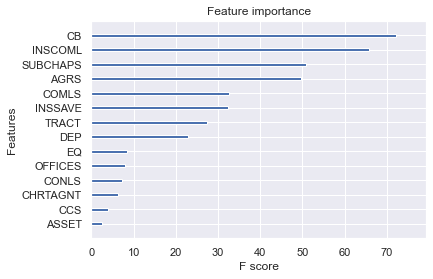

In [113]:
#plot default feature importance - not as good as shap output
xgb.plot_importance(bst, importance_type = 'gain', show_values = False)

Above is a default feature importance method that is part of the xgboost package. There are a few different options for measuring feature importance, as given by the ```importance_type``` argument. From my external research, ```gain``` is the most relevant of these options for interpreting relative importance of each feature, as 'gain' is the improvement in accuracy brought by a feature to the branches it is on (xgboost uses parallel tree boosting). However, there a few problems with this output alone. First, while we get a sense of which variables were most important for the model, there is no indication of the direction in which each feature is impacting our prediction. For example, the output indiciates that the CB variable was significant, but we don't know if being a Community Bank increases or decreases the probability of having good bank performance. Additionally, my outside research indicated that the 'gain' measure used by XGBoost can be inconsistent. To resolve both of these issues, I did some more research and discovered a separate package called ```shap``` that can complement the xgboost output to give a more relevant and meaningful output. SHAP values were developed to provide both accuracy and consistency when interpreting tree models like those produced by XGBoost. More detailed information on this can be found in the article linked in my references. But since my research suggests that SHAP is the most comprehensive method for analyzing feature importance, I will primarily discuss these results. The output of feature importance using this ```shap``` package is next.

#### SHAP Feature Importance

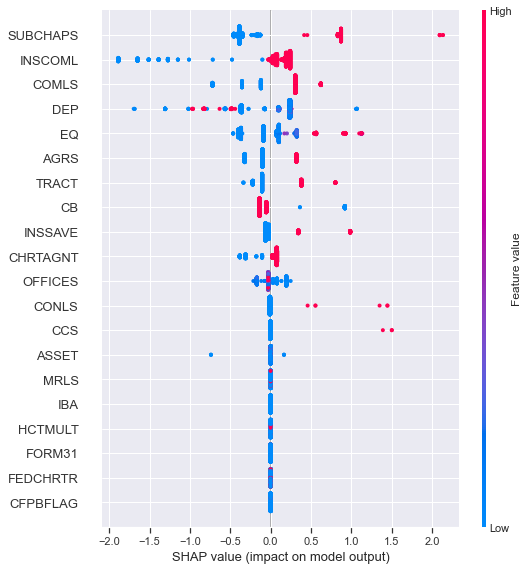

In [114]:
#print shap output - very helpful for understanding variable importance
shape_values = shap.TreeExplainer(bst).shap_values(test)
shap.summary_plot(shape_values, test)

Above is the SHAP summary plot - variables are ranked top to bottom by average SHAP score, which is a great indicator of variable importance. For example, we can say that SUBCHAPS is the most important feature in our model, according to SHAP score. This plot seems a bit daunting at first, but once it is understood, it gives many great insights. For each variable on the plot (each row), there is a dot for every bank in our test dataset. Datapoints that are 'high' in value are more red, while low ones are closer to blue (note that since most of these variables are flag/indicator variables, there are often only two colors, blue for 0 and red for 1). The x position of each point is plotted based on the impact on the model's prediction for that bank (positive SHAP value, higher prediction). For example, if we look at the SUBCHAPS feature, every bank with a '1' for the SUBCHAPS variable has a postitive SHAP value, so it's increasing our predicted value; and each bank with a '0' has a negative SHAP value. This tells us that on average, being a Subchapter S Corporation is correlated with higher ROA, or at least a higher probability of having a ROA above 1%! 

### Results

From the SHAP plot above, we obtain the following list of structural features that were the most important in our model (ranked in order of importance). I try to keep each summary clear and concise, so elaborative notes can be found below the list.

1. **Subchapter S Corporation** (SUBCHAPS) - Our model found that being a Subchapter S Corporation is strongly correlated with having *stronger performance*<sup>1</sup>, as compared to institutions that are not S Corporations. A Subchapter S corporation is treated as a pass-through entity for federal income tax purpose and is generally not subject to any federal income taxes at the corporate level.
2. **Insured Commerical Banks** (INSCOML) - Our model found that being an Insured Commercial Bank is strongly correlated with having *stronger performance*, as compared to institutions not listed as Insured Commerical Banks. This title includes commercial banks insured by the FDIC and are regulated by one of the three Federal commercial bank regulators (FDIC, Federal Reserve Board, or Office of the Comptroller of the Currency).
3. **Commercial Lending Specialization** (COMLS) - Our model found that being specialized in Commerical Lending is strongly correlated with having *stronger performance*, as compared to institutions having no specialization<sup>2</sup>.
4. **Total Deposits** (DEP) - If anything, our model found that higher deposits may be correlated with *slightly weaker performance*, though this is a bit unclear - looking at the SHAP plot above, we see that both high and low values for deposits are associated with a negative SHAP value, but mostly low values associate with a positive SHAP value. The interpretation of this output is much less straightforward than the previous three, so we can't really make any definitive conclusions from this output.
5. **Equity Capital** (EQ) - Our model found that having high equity capital is moderately correlated with *stronger performance*. Again, this interpretation is not entirely clear cut like the first three, but in this case, the plot does give enough evidence to conclude that there is a moderate correlation. 
6. **Agricultural Specializaton** (AGRS) - Our model found that being specialized in Agriculture is moderately correlated with *stronger performance*, as compared to institutions having no specialization.
7. **TRACT** (Tract) - This feature is moderately correlated with *stronger performance* - unfortunately, the title for this variable in the BankFind API is empty, but the description is as follows: beyond having trust powers granted and exercised, institutions with fiduciary assets accounts, income, or other reportable fiduciary related service. 
8. **Community Bank** (CB) - Our model found that being a community bank is moderately correlated with *weaker peformance*. Community banks are identified in the FDIC Community Banking Study, which defines community banks in terms of their traditional relationship banking and limited geographic scope of operations.
9. **Insured Savings Institution** (INSSAVE) - Our model found that being an Insured Savings Institutions is moderately correlated with *stronger performance*. These include savings institutions insured by the FDIC that operate under state or federal banking codes applicable to thrift institutions.
10. **Chartering Agency** - Our model found that having the 'STATE' as the chartering agency is moderately correlated with *stronger performance*, as compared to institutions whose chartering agent is listed as the 'OCC'.

No correlation was found for all other variables used in our model, as they were either not significant or gave output too ambiguous to draw conclusions from. 

Notes:\
<sup>1</sup> In each instance, I use the term 'performance' loosely for ease and simplicity: 'performance' technically represents the probability of having on ROA greater than 1% (stronger performance = higher probability)\
<sup>2</sup> Possible specializations include commericial lending, agricultural, consumer lending, credit cards, international, over 1 billion, and mortage lending - all others who don't fit into one of these constitute the 'no specialization' subset

# Section 5: Conclusion
Looking back on the process I took and my results, there are a few concluding reflections to make. First, I have done my best to use accurate language when discussing the statistics involved to avoid implying something not proven by the model. Particularly, the distinction between *correlation* and *causation* is important to keep in mind. The model I have created uses machine learning to extract the correlations that exist between the input variables and ROA, but nothing in my model can prove that any of these input variables *cause* changes to a bank's ROA or performance. This model answers the question 'which structural variables are associated with strong bank performance', and *not* 'which structural variables cause a bank to perform better or worse'. In this case, the first question is all we were looking to answer; if we wanted to instead address the second question, we would require a different process and model.

Secondly, I would like to revisit my choice of bank performance metric now that the model and results are complete. Overall, I think that using ROA was successful in giving a general sense of which features were associated with stronger bank performance. However, I did notice one possible issue that ROA may have presented in this model, specifically with the Subchapter S Corporation variable. Since Return on Assets is calculated from net income *after* taxes, this may have introduced a slight bias towards S Corporations, since these corporations do not generally pay federal income tax at the corporate level. I only noticed this issue for this specific variable, and this may require a bit more outside research to fully understand, but I thought it would be important to mention as a caveat for that result. It may be helpful to eventually develop a similar model, using a different measure for bank performance that does not present this bias, if needed.

###  What Comes Next?

Finally, I'd like to briefly comment on possible next steps for leveraging BankFind now that I have spent some time with it. In this analysis, I used exclusively the 'Institutions' endpoint since I chose to focus on researching the structural features of institutions and how they correlate with bank performance. Another very useful endpoint that could be helpful in future projects is the 'Financials' endpoint. I practiced with this endpoint, but was really only able to explore the tip of the iceberg. This endpoint is the largest of all six by a LOT, and contains over 1.5 Million records, each with over 1000 return variables, containing historical, quarterly financial data for these intitutions. This endpoint would be of great use for any longitudunal or time-series analysis that is needed. Interfacing with this endpoint is naturally more difficult due to the scale of it - my ```search``` function worked perfecty fine returning results numbering in the low thousands or less but was very limited when it came to returning large batches of this financial data. But overall, further exporation of the financials data could prove useful moving forward.

### References

- BankFind API Docs - https://banks.data.fdic.gov/docs/#/
- TowardsDataScience Article on SHAP and XGBoost- https://towardsdatascience.com/interpretable-machine-learning-with-xgboost-9ec80d148d27
- XGBoost Python Docs - https://xgboost.readthedocs.io/en/latest/python/python_api.html